# Data acquisition

In [82]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

#sklearn.set_config(enable_metadata_routing=True)

In [83]:
df_raw = pd.read_csv('https://github.com/kedarwent/Shipping-inspection-classifier/blob/main/shipping_data_summative.csv')

In [84]:
df_raw.head(3)

name  price ($)  weight (kg)  length (m)  width (m)  \
0    Pallete of Orange Juice     210.44       591.77        1.02       0.88   
1  Big Bag with Metal Scraps     195.60      1727.34        1.85       1.14   
2               Coffee Maker      96.32         1.08        0.23       0.22   

   height (m) shipment date           port of loading  Vessel  \
0        1.50    24/06/2022  Port of Shanghai (China)   LINDA   
1        0.12    12/11/2022     Port of Tokyo (Japan)  AURORA   
2        0.27    09/06/2022  Port of Shanghai (China)    HANA   

   Dwell after shipping  Customer Called for inspection  
0                    47        11                     Y  
1                    88         8                     N  
2                    15        14                     Y

In [85]:
df_raw.shape

(2500, 12)

# Data cleaning

In [86]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   name                   2500 non-null   object 
 1   price ($)              2500 non-null   float64
 2   weight (kg)            2500 non-null   float64
 3   length (m)             2498 non-null   float64
 4   width (m)              2500 non-null   float64
 5   height (m)             2500 non-null   float64
 6   shipment date          2474 non-null   object 
 7   port of loading        2500 non-null   object 
 8   Vessel                 2500 non-null   object 
 9   Dwell after shipping   2500 non-null   int64  
 10  Customer               2500 non-null   int64  
 11  Called for inspection  2500 non-null   object 
dtypes: float64(5), int64(2), object(5)
memory usage: 234.5+ KB


In [87]:
df_raw['shipment date'] = pd.to_datetime(df_raw['shipment date'], format='%d/%m/%Y')
df_raw['Customer'] = df_raw['Customer'].astype('int', errors='ignore')

Since the customer number is just an anonymising encoding of a customer's identity, and has no significance, we should alter this to a non-numerical value to avoid the model deducing non-existent patterns between customer ID and other variables. If the number of unique values is less than 26, we could simply map the letters of the alphabet onto the values.

In [88]:
df_raw['Customer'].unique()

array([11,  8, 14,  6, 20,  2, 10, 13,  4,  5, 19, 16, 12,  3, 15,  9,  1,
       17,  7, 18, 21])

In [89]:
df_raw['Customer'] = df_raw['Customer'].apply(lambda x: chr(64+x))

In [90]:
df_raw['Customer'].unique()

array(['K', 'H', 'N', 'F', 'T', 'B', 'J', 'M', 'D', 'E', 'S', 'P', 'L',
       'C', 'O', 'I', 'A', 'Q', 'G', 'R', 'U'], dtype=object)

The values in 'Customer' are now uppercase letters.

In [91]:
df_raw.describe().round(3)

price ($)  weight (kg)  length (m)  width (m)  height (m)  \
count     2500.000     2500.000    2498.000   2500.000    2500.000   
mean      5875.059      332.007       0.963      0.538       0.466   
std      81340.818     1649.015       1.908      0.453       0.501   
min          2.090        0.050       0.050      0.020       0.010   
25%         28.710        0.690       0.290      0.220       0.130   
50%         92.170        2.900       0.600      0.390       0.260   
75%        273.155       66.975       1.140      0.800       0.660   
max    1814302.690    24671.600      28.830      5.240       5.540   

       Dwell after shipping  
count              2500.000  
mean                 45.734  
std                  21.694  
min                   1.000  
25%                  30.000  
50%                  46.000  
75%                  63.000  
max                 104.000

In [92]:
l1 = ['price ($)', 'weight (kg)', 'length (m)']
l2 = ['width (m)', 'height (m)', 'Dwell after shipping']

fig, ax = plt.subplots(2,3, figsize=(15,10))

n = 0
for i in l1:
    sns.histplot(df_raw[i], bins=10, ax=ax[0][n]).set_title(f'Distribution of {i}', size=12, pad=5)
    n += 1
n = 0
for i in l2:
    sns.histplot(df_raw[i], bins=10, ax=ax[1][n]).set_title(f'Distribution of {i}', size=12, pad=5)
    n += 1

In [93]:
l1=['price ($)', 'weight (kg)', 'length (m)']
l2 = ['width (m)', 'height (m)', 'Dwell after shipping']

fig, ax = plt.subplots(2,3, figsize=(15,10))

n = 0
for i in l1:
    sns.boxplot(df_raw[i], ax=ax[0][n]).set_title(f'Distribution of {i}', size=10, pad=5)
    n += 1

n = 0
for i in l2:
    sns.boxplot(df_raw[i], ax=ax[1][n]).set_title(f'Distribution of {i}', size=10, pad=5)
    n += 1

In [94]:
for i in df_raw.columns:
    if df_raw[i].isna().sum() != 0:
        print(i, ": ", df_raw[i].isna().sum())

length (m) :  2
shipment date :  26


In [95]:
df_missing = df_raw

In [96]:
df_missing['missing date'] = df_missing['shipment date'].fillna(0).apply(lambda x: 0 if x == 0 else 1)
df_missing['Called for inspection'] = df_missing['Called for inspection'].map({'Y': 1, 'N': 0})

In [97]:
df_missing

name  price ($)  weight (kg)  length (m)  \
0            Pallete of Orange Juice     210.44       591.77        1.02   
1          Big Bag with Metal Scraps     195.60      1727.34        1.85   
2                       Coffee Maker      96.32         1.08        0.23   
3     Pallete of Musical Instruments     885.97      1603.18        1.03   
4                  Tomatoes (Canned)    1003.67        79.86        0.40   
...                              ...        ...          ...         ...   
2495                         Tablets     920.36         0.27        0.87   
2496               Pallete of Plants     289.01       503.79        1.03   
2497                Pallete of Books     169.79       836.95        0.59   
2498                    Running Belt      22.74         0.12        0.21   
2499                  Garden Sprayer      38.81         2.20        0.31   

      width (m)  height (m) shipment date              port of loading  \
0          0.88        1.50    2022-06-24     Port of Shanghai (China)   
1          1.14        0.12    2022-11-12        Port of Tokyo (Japan)   
2          0.22        0.27    2022-06-09     Port of Shanghai (China)   
3          0.90        0.52    2022-12-08      Port of Tianjin (China)   
4          0.30        0.30    2022-12-25      Port of Tianjin (China)   
...         ...         ...           ...                          ...   
2495       0.23        0.21    2022-11-08     Port of Shanghai (China)   
2496       0.98        1.43    2022-02-04  Port of Busan (South Korea)   
2497       0.33        1.09    2022-07-18      Port of Tianjin (China)   
2498       0.09        0.09    2022-02-25  Port of Busan (South Korea)   
2499       0.31        0.29    2022-12-19     Port of Shanghai (China)   

      Vessel  Dwell after shipping Customer  Called for inspection  \
0      LINDA                    47        K                      1   
1     AURORA                    88        H                      0   
2       HANA                    15        N                      1   
3       HANA                    73        F                      0   
4       HANA                    65        F                      0   
...      ...                   ...      ...                    ...   
2495    HANA                     3        P                      1   
2496  SERENA                    16        K                      1   
2497   LINDA                    58        O                      0   
2498  AMELIA                    67        Q                      0   
2499    HANA                    72        C                      0   

      missing date  
0                1  
1                1  
2                1  
3                1  
4                1  
...            ...  
2495             1  
2496             1  
2497             1  
2498             1  
2499             1  

[2500 rows x 13 columns]

In [98]:
df_missing['missing date'].describe()

count    2500.000000
mean        0.989600
std         0.101469
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: missing date, dtype: float64

In [99]:
fig, ax = plt.subplots(1,2, figsize=(20,6))
sns.heatmap(df_missing.corr(method='spearman'), annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1, center=0, ax=ax[0]).set_title('Correlation matrix (Spearmans\'s rank)', size=20, pad=15)
sns.heatmap(df_missing.corr(method='pearson'), annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1, center=0).set_title('Correlation matrix (Pearson\'s $r$)', size=20, pad=15)

Text(0.5, 1.0, "Correlation matrix (Pearson's $r$)")

In [100]:
d = df_missing.assign(vals=1).pivot_table(values = 'vals', 
                                      columns='missing date', 
                                      index='port of loading', 
                                      aggfunc='count').apply(lambda x: x*100 / float(x.sum()), axis=1)
d = pd.DataFrame(d)
d

missing date                          0          1
port of loading                                   
Port of Busan (South Korea)    0.984252  99.015748
Port of Shanghai (China)       1.544402  98.455598
Port of Singapore (Singapore)  0.210084  99.789916
Port of Tianjin (China)        1.228070  98.771930
Port of Tokyo (Japan)          1.168224  98.831776

In [101]:
dd = df_missing.assign(vals=1).pivot_table(values = 'vals', 
                                      columns='Called for inspection', 
                                      index='port of loading', 
                                      aggfunc='count').apply(lambda x: x*100 / float(x.sum()), axis=1)
dd = pd.DataFrame(dd)
dd.rename({0:'N', 1:'Y'}, axis=1, inplace=True)
dd

Called for inspection                  N          Y
port of loading                                    
Port of Busan (South Korea)    93.700787   6.299213
Port of Shanghai (China)       64.092664  35.907336
Port of Singapore (Singapore)  99.369748   0.630252
Port of Tianjin (China)        68.771930  31.228070
Port of Tokyo (Japan)          99.065421   0.934579

In [102]:
ddd = pd.concat([d, dd], axis=1, ignore_index=False)
ddd.rename({0: 'missing date', 1: 'no missing date', 'N': 'no inspection', 'Y': 'inspection'}, axis=1, inplace=True)
ddd.sort_values(by='missing date', ascending=False)
ddd['port of loading'] = ddd.index
ddd

missing date  no missing date  no inspection  \
port of loading                                                               
Port of Busan (South Korea)        0.984252        99.015748      93.700787   
Port of Shanghai (China)           1.544402        98.455598      64.092664   
Port of Singapore (Singapore)      0.210084        99.789916      99.369748   
Port of Tianjin (China)            1.228070        98.771930      68.771930   
Port of Tokyo (Japan)              1.168224        98.831776      99.065421   

                               inspection                port of loading  
port of loading                                                           
Port of Busan (South Korea)      6.299213    Port of Busan (South Korea)  
Port of Shanghai (China)        35.907336       Port of Shanghai (China)  
Port of Singapore (Singapore)    0.630252  Port of Singapore (Singapore)  
Port of Tianjin (China)         31.228070        Port of Tianjin (China)  
Port of Tokyo (Japan)            0.934579          Port of Tokyo (Japan)

In [103]:
ddd = pd.get_dummies(ddd, columns=['port of loading'])

In [104]:
ddd

missing date  no missing date  no inspection  \
port of loading                                                               
Port of Busan (South Korea)        0.984252        99.015748      93.700787   
Port of Shanghai (China)           1.544402        98.455598      64.092664   
Port of Singapore (Singapore)      0.210084        99.789916      99.369748   
Port of Tianjin (China)            1.228070        98.771930      68.771930   
Port of Tokyo (Japan)              1.168224        98.831776      99.065421   

                               inspection  \
port of loading                             
Port of Busan (South Korea)      6.299213   
Port of Shanghai (China)        35.907336   
Port of Singapore (Singapore)    0.630252   
Port of Tianjin (China)         31.228070   
Port of Tokyo (Japan)            0.934579   

                               port of loading_Port of Busan (South Korea)  \
port of loading                                                              
Port of Busan (South Korea)                                              1   
Port of Shanghai (China)                                                 0   
Port of Singapore (Singapore)                                            0   
Port of Tianjin (China)                                                  0   
Port of Tokyo (Japan)                                                    0   

                               port of loading_Port of Shanghai (China)  \
port of loading                                                           
Port of Busan (South Korea)                                           0   
Port of Shanghai (China)                                              1   
Port of Singapore (Singapore)                                         0   
Port of Tianjin (China)                                               0   
Port of Tokyo (Japan)                                                 0   

                               port of loading_Port of Singapore (Singapore)  \
port of loading                                                                
Port of Busan (South Korea)                                                0   
Port of Shanghai (China)                                                   0   
Port of Singapore (Singapore)                                              1   
Port of Tianjin (China)                                                    0   
Port of Tokyo (Japan)                                                      0   

                               port of loading_Port of Tianjin (China)  \
port of loading                                                          
Port of Busan (South Korea)                                          0   
Port of Shanghai (China)                                             0   
Port of Singapore (Singapore)                                        0   
Port of Tianjin (China)                                              1   
Port of Tokyo (Japan)                                                0   

                               port of loading_Port of Tokyo (Japan)  
port of loading                                                       
Port of Busan (South Korea)                                        0  
Port of Shanghai (China)                                           0  
Port of Singapore (Singapore)                                      0  
Port of Tianjin (China)                                            0  
Port of Tokyo (Japan)                                              1

In [105]:
sns.heatmap(ddd.corr(method='spearman'), annot=True, fmt='.2f', cmap='vlag', vmin=-1, vmax=1, center=0).set_title('Correlation matrix (Spearman\'s rank)', size=20, pad=15)

Text(0.5, 1.0, "Correlation matrix (Spearman's rank)")

As the number of rows missing values for 'weight (kg)' and 'port of loading' is so small, is it more effective to drop them from the dataset than attempt to interpolate or otherwise attempt to predict the missing values.

In [106]:
df = df_raw
df = df[(~df['weight (kg)'].isna()) & (~df['port of loading'].isna())]

In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2500 entries, 0 to 2499
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   2500 non-null   object        
 1   price ($)              2500 non-null   float64       
 2   weight (kg)            2500 non-null   float64       
 3   length (m)             2498 non-null   float64       
 4   width (m)              2500 non-null   float64       
 5   height (m)             2500 non-null   float64       
 6   shipment date          2474 non-null   datetime64[ns]
 7   port of loading        2500 non-null   object        
 8   Vessel                 2500 non-null   object        
 9   Dwell after shipping   2500 non-null   int64         
 10  Customer               2500 non-null   object        
 11  Called for inspection  2500 non-null   int64         
 12  missing date           2500 non-null   int64         
dtypes: 

In [108]:
df['name'].describe(include='all').T

count             2500
unique             289
top       Hiking Boots
freq                31
Name: name, dtype: object

As 'name' is a highly varied categorical variable, where the most frequent value accounts for only ~1.2% of rows, this column would be difficult to process to data which is in a useful format. It may be wortwhile dropping this column, in order to speed up the model and prevent it drawing false correlations.

In [109]:
df = df.drop('name', axis=1)

In [110]:
df['shipment date'].dt.year.unique()

array([2022.,   nan])

In [111]:
df['weekday'] = df['shipment date'].dt.weekday
df['shipment day'] = df['shipment date'].dt.day
df['shipment month'] = df['shipment date'].dt.month

In [112]:
df = df.drop('shipment date', axis=1)

# Data pre-processing

The data needs to be split into feature and target variables: the variables which will be input into the model, and the variable which the model is expected to predict. I will name these _X_ and _y_.

In [113]:
y = pd.DataFrame(df['Called for inspection'])

In [114]:
X = df.drop('Called for inspection', axis=1)

The numerical data needs to be scaled; unscaled data can distort the interpretatins of distance-based models like KNN and SVM (CHong, 2020).
De Amorim et al (2023) in their analysis of the effects of different scaling methods on various model types show the standard scaler is generally the better scaler to use, and is especially suited to KNN, linear SVM, decision trees and bagging methods. 

The categorical data needs to be converted to numerical data. sklearn offers label encoding, where each unique value in a column is assigned an integer; this, however, can make it seem as if there were some ordinality between values (i.e. that there is rankign between values), which may not be true (Zach, 2022). One-hot encoding transforms the dataframe, creating a column for each unique category and assigning a 0 or 1 value if the original value of the untransformed column was the header of the new column. 

In [115]:
cat_vars = ['port of loading', 'Vessel', 'Customer']
df_categorical = X[cat_vars]
df_numerical = X.drop(cat_vars, axis=1)
num_vars = X.columns.drop(cat_vars)

In [116]:
num_vars

Index(['price ($)', 'weight (kg)', 'length (m)', 'width (m)', 'height (m)',
       'Dwell after shipping', 'missing date', 'weekday', 'shipment day',
       'shipment month'],
      dtype='object')

In [117]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [118]:
enc_cat = OneHotEncoder(handle_unknown='ignore', min_frequency=2, sparse_output=False)

In [119]:
enc_num = StandardScaler()

In [120]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer([('OneHotEncoder', enc_cat, cat_vars), ('StandardScaler', enc_num, num_vars)], 
                                 sparse_threshold=0.5)

https://inria.github.io/scikit-learn-mooc/python_scripts/03_categorical_pipeline_column_transformer.html

In [121]:
preprocessed_df = pd.DataFrame(preprocessor.fit_transform(df))

## Imputing missing values

In [122]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=5)

In [123]:
imputed_arr = imputer.fit_transform(preprocessed_df)

In [124]:
df_imp = pd.DataFrame(imputed_arr)

In [125]:
for i in df_imp.columns:
    if df_imp[i].isna().sum() > 0:
        print(i, ": ", df_imp[i].isna().sum())

In [126]:
df_imp.head(3)

0    1    2    3    4    5    6    7    8    9   ...        32        33  \
0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ... -0.069654  0.157558   
1  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  ... -0.069837  0.846331   
2  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ... -0.071058 -0.200721   

         34        35        36        37        38        39        40  \
0  0.029620  0.755272  2.066314  0.058387  0.102515  0.492473  0.942801   
1  0.464649  1.329899 -0.691158  1.948690  0.102515  0.993862 -0.418177   
2 -0.384443 -0.703397 -0.391433 -1.416971  0.102515 -0.008917 -0.758421   

         41  
0 -0.161017  
1  1.284394  
2 -0.161017  

[3 rows x 42 columns]

In [127]:
X = df_imp

## Putting back column names

In [128]:
preprocessor.named_transformers_

{'OneHotEncoder': OneHotEncoder(handle_unknown='ignore', min_frequency=2, sparse_output=False),
 'StandardScaler': StandardScaler(),
 'remainder': 'drop'}

In [129]:
enc_cat_features = preprocessor.named_transformers_['OneHotEncoder'].get_feature_names_out()

In [130]:
enc_cat_features

array(['port of loading_Port of Busan (South Korea)',
       'port of loading_Port of Shanghai (China)',
       'port of loading_Port of Singapore (Singapore)',
       'port of loading_Port of Tianjin (China)',
       'port of loading_Port of Tokyo (Japan)', 'Vessel_AMELIA',
       'Vessel_AURORA', 'Vessel_HANA', 'Vessel_LINDA', 'Vessel_SAKURA',
       'Vessel_SERENA', 'Customer_A', 'Customer_B', 'Customer_C',
       'Customer_D', 'Customer_E', 'Customer_F', 'Customer_G',
       'Customer_H', 'Customer_I', 'Customer_J', 'Customer_K',
       'Customer_L', 'Customer_M', 'Customer_N', 'Customer_O',
       'Customer_P', 'Customer_Q', 'Customer_R', 'Customer_S',
       'Customer_T', 'Customer_infrequent_sklearn'], dtype=object)

In [131]:
enc_num_features = preprocessor.named_transformers_['StandardScaler'].get_feature_names_out()

In [132]:
enc_num_features

array(['price ($)', 'weight (kg)', 'length (m)', 'width (m)',
       'height (m)', 'Dwell after shipping', 'missing date', 'weekday',
       'shipment day', 'shipment month'], dtype=object)

In [133]:
coldict = {}
x=0

for i in enc_cat_features:
    coldict[x] = i
    x +=1

for j in enc_num_features:
    coldict[x] = j
    x += 1
    
X = X.rename(mapper=coldict, axis=1)

In [134]:
X

port of loading_Port of Busan (South Korea)  \
0                                             0.0   
1                                             0.0   
2                                             0.0   
3                                             0.0   
4                                             0.0   
...                                           ...   
2495                                          0.0   
2496                                          1.0   
2497                                          0.0   
2498                                          1.0   
2499                                          0.0   

      port of loading_Port of Shanghai (China)  \
0                                          1.0   
1                                          0.0   
2                                          1.0   
3                                          0.0   
4                                          0.0   
...                                        ...   
2495                                       1.0   
2496                                       0.0   
2497                                       0.0   
2498                                       0.0   
2499                                       1.0   

      port of loading_Port of Singapore (Singapore)  \
0                                               0.0   
1                                               0.0   
2                                               0.0   
3                                               0.0   
4                                               0.0   
...                                             ...   
2495                                            0.0   
2496                                            0.0   
2497                                            0.0   
2498                                            0.0   
2499                                            0.0   

      port of loading_Port of Tianjin (China)  \
0                                         0.0   
1                                         0.0   
2                                         0.0   
3                                         1.0   
4                                         1.0   
...                                       ...   
2495                                      0.0   
2496                                      0.0   
2497                                      1.0   
2498                                      0.0   
2499                                      0.0   

      port of loading_Port of Tokyo (Japan)  Vessel_AMELIA  Vessel_AURORA  \
0                                       0.0            0.0            0.0   
1                                       1.0            0.0            1.0   
2                                       0.0            0.0            0.0   
3                                       0.0            0.0            0.0   
4                                       0.0            0.0            0.0   
...                                     ...            ...            ...   
2495                                    0.0            0.0            0.0   
2496                                    0.0            0.0            0.0   
2497                                    0.0            0.0            0.0   
2498                                    0.0            1.0            0.0   
2499                                    0.0            0.0            0.0   

      Vessel_HANA  Vessel_LINDA  Vessel_SAKURA  ...  price ($)  weight (kg)  \
0             0.0           1.0            0.0  ...  -0.069654     0.157558   
1             0.0           0.0            0.0  ...  -0.069837     0.846331   
2             1.0           0.0            0.0  ...  -0.071058    -0.200721   
3             1.0           0.0            0.0  ...  -0.061348     0.771022   
4             1.0           0.0            0.0  ...  -0.059901    -0.152938   
...           ...           ...            ...  ...        ...          ...   
2495          1.0           0.0         

# Data exploration & visualisation

We can see the correlations between all the variables in the X dataframe

<AxesSubplot:>

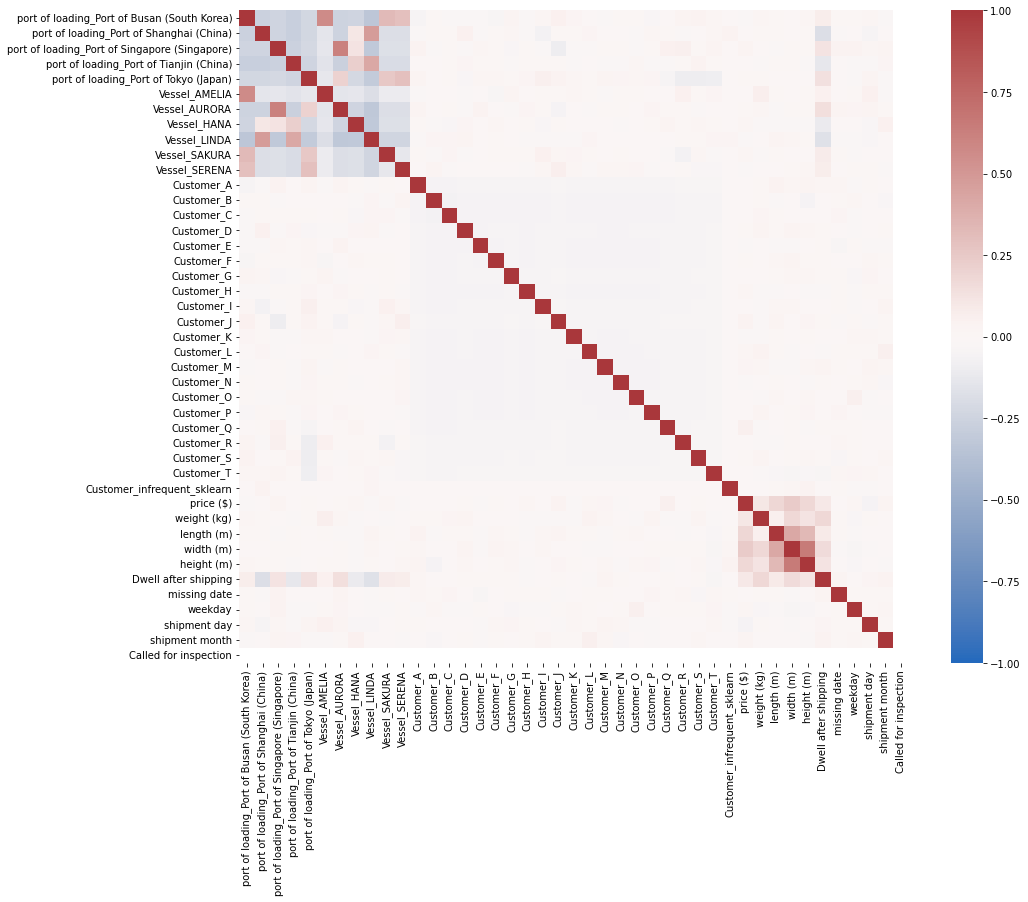

In [135]:
y2 = y['Called for inspection'].map({'Y': 1, 'N': 0})
X_and_y = pd.concat([X, y2], axis=1)
corr = X_and_y.corr()

fig = plt.figure(figsize = (15,12))
ax = fig.add_subplot(1,1,1)
sns.heatmap(corr, cmap='vlag', center=0, vmin=-1, vmax=1, ax=ax)

There are many zero (or near-zero) correlations. However, being called for inspection appears to be strongly negatively correlated with to dwell time. This appears based on the assumption that criminals would conceal illegal goods in fast-moving consignments which leave the port quickly, helping them avoid detection.
<br>Inspection also appears to be more likely for consignments coming from China (with Port of Shanghai and Port of Tianjin looking about equally likely). Consignments coming in on the vessels _Hana_ and _Linda_ are more likely to be inspected; this could be collinearity, with vessel acting as a mediator variable influenced by port,  as there is a positive correlation between these vessels and the Chinese ports.
<br> Dwell also appears to be influenced slightly by vessel and port. However, this may be collinearity rather than an actual direct relationship.
<br>There is also strong correlation between the physical dimensions and weight of consignments, and weak correlation between these and dwell; This is also true for more expnsive consignments. Putting this in relation to our target feature, this (indirectly) makes more expensive consignments slightly less likely to be picked for inspection.

In [136]:
corrdict = {}

for i in corr.columns:
    for j in corr.index:
        if abs(corr[i][j]) >= 0.3 and abs(corr[i][j]) != 1.0:
            if (j, i) not in corrdict.keys():
                corrdict[(i, j)] = corr[i][j]
import pprint
pprint.pp(corrdict)

{('port of loading_Port of Busan (South Korea)', 'Vessel_AMELIA'): 0.5646740380090344,
 ('port of loading_Port of Busan (South Korea)', 'Vessel_LINDA'): -0.32996732583530847,
 ('port of loading_Port of Busan (South Korea)', 'Vessel_SAKURA'): 0.3273001979567635,
 ('port of loading_Port of Shanghai (China)', 'Vessel_LINDA'): 0.48066041838566803,
 ('port of loading_Port of Singapore (Singapore)', 'Vessel_AURORA'): 0.6206619604379158,
 ('port of loading_Port of Singapore (Singapore)', 'Vessel_LINDA'): -0.31687061758181123,
 ('port of loading_Port of Tianjin (China)', 'Vessel_LINDA'): 0.41529163333792857,
 ('Vessel_AURORA', 'Vessel_LINDA'): -0.3279281569039041,
 ('Vessel_HANA', 'Vessel_LINDA'): -0.3168706175818122,
 ('length (m)', 'width (m)'): 0.4175162643408181,
 ('length (m)', 'height (m)'): 0.3345191850804236,
 ('width (m)', 'height (m)'): 0.6535764277896023}


<AxesSubplot:xlabel='Called for inspection', ylabel='count'>

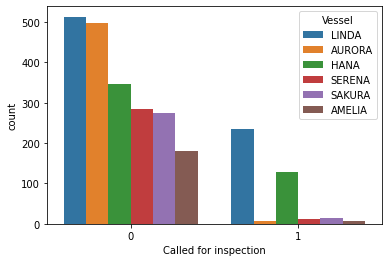

In [137]:
sns.countplot(data=df, x='Called for inspection', hue='Vessel')

In [138]:
sns.countplot(data=df, x='Called for inspection', hue='port of loading')

<AxesSubplot:xlabel='Called for inspection', ylabel='count'>

In [139]:
sns.scatterplot(data=df, y='Called for inspection', x='Dwell after shipping', hue='port of loading')

<AxesSubplot:xlabel='Dwell after shipping', ylabel='Called for inspection'>

It would be useful if we could reduce the dimensionality of the dataset; this would avoid the risk we run of encountering the curse of dimensionality (Lindgren, 2020), which can be seen in datasets with only 10 features (Debbie & Shafi, 2019).

In [140]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [141]:
principalDf

principal component 1  principal component 2
0                  1.518174              -0.234168
1                  1.181737               1.863352
2                 -1.164299              -1.082367
3                  0.976982               1.086517
4                 -0.578770               1.283301
...                     ...                    ...
2495              -1.140986              -1.276021
2496               1.325925              -1.824604
2497               0.541295               0.344742
2498              -1.030212               1.032958
2499              -0.380159               1.189434

[2500 rows x 2 columns]

In [142]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [143]:
finalDf

principal component 1  principal component 2  Called for inspection
0                  1.518174              -0.234168                      1
1                  1.181737               1.863352                      0
2                 -1.164299              -1.082367                      1
3                  0.976982               1.086517                      0
4                 -0.578770               1.283301                      0
...                     ...                    ...                    ...
2495              -1.140986              -1.276021                      1
2496               1.325925              -1.824604                      1
2497               0.541295               0.344742                      0
2498              -1.030212               1.032958                      0
2499              -0.380159               1.189434                      0

[2500 rows x 3 columns]

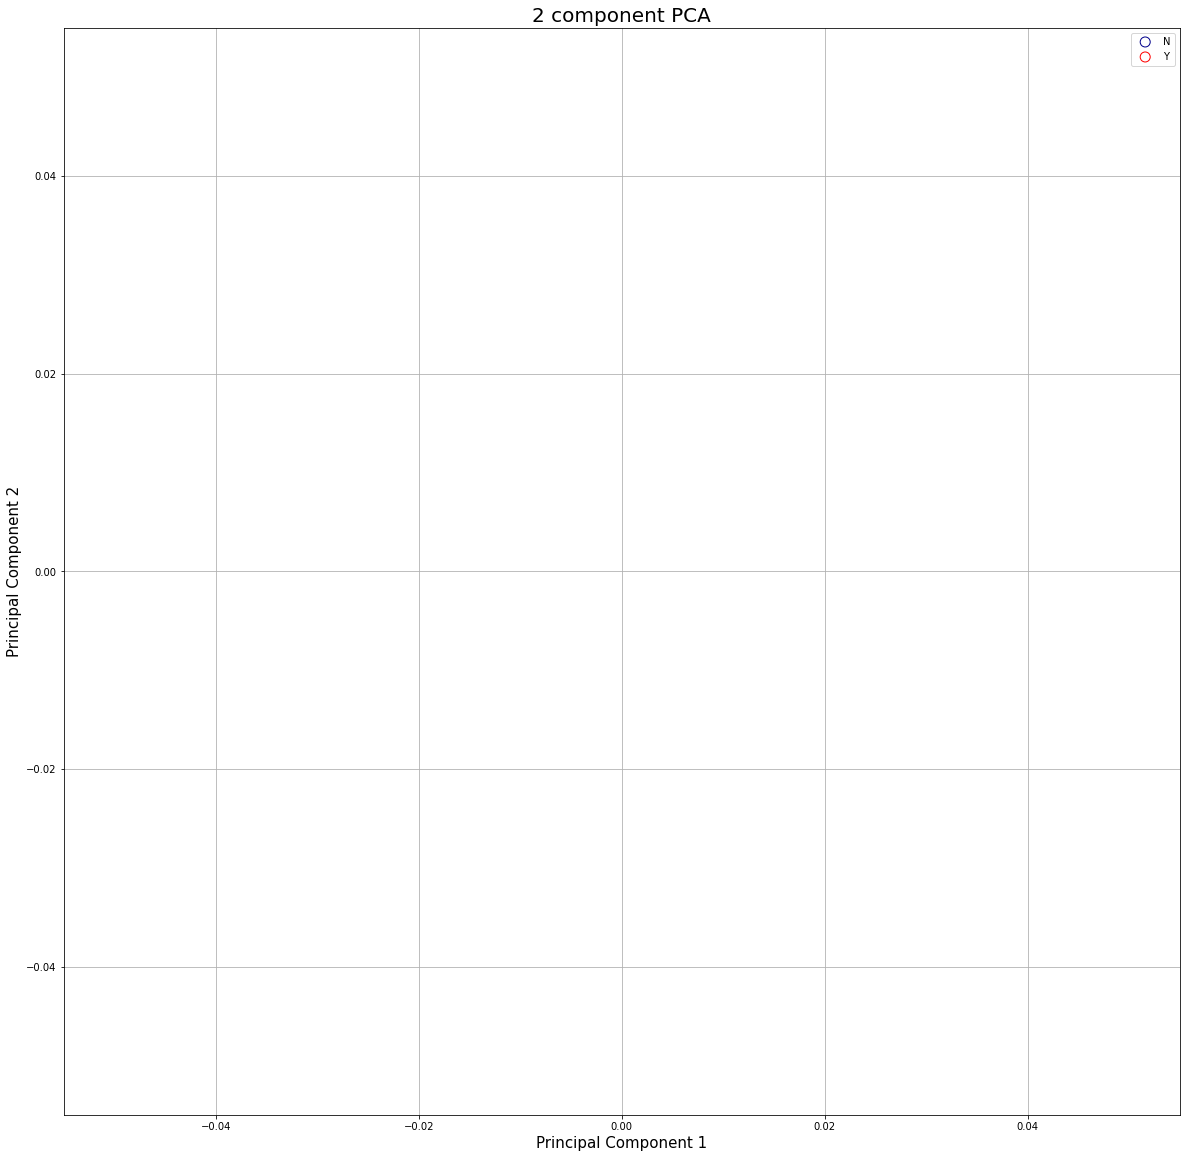

In [175]:
fig = plt.figure(figsize = (20,20))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['N', 'Y']
colours = ['darkblue', 'red']
for target, colour in zip(targets,colours):
    indicesToKeep = finalDf['Called for inspection'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], finalDf.loc[indicesToKeep, 'principal component 2'], 
               edgecolor = colour, facecolor='none', s = 100)
ax.legend(targets)
ax.grid()
plt.show(fig)

Although this graph shows _some_ separation between the "yes" and "no" classes, there looks to be some overlap, as the principle components did not contain enough of the variance to keep the data seperable as it was compressed to a lower-dimension space. 
<br>This indicates that PCA was not the most suitable tool to use on this dataset; from this, we can gather that the most effective model type to use would be one which is good at handling datasets of high dimensionality, such as decision tree, random forest, or support vector machine.

In [145]:
pca.explained_variance_ratio_

array([0.17394685, 0.09015638])

To reiterate the point on the unsuitablity of PCA for this dataset, the cell above shows the proportion of variance (information which can be meaningfully used in classifying) in the dataset which the principle components contain. Some variance is typically lost converting from a higher- to lower-dimension space; we obviously want to reduce this as much as possible.
<br>The 2 principle components combined only contain <30% of the total variance.

# Data modelling

First, we need to split our dataset into training, testing and validation datasets.
https://www.v7labs.com/blog/train-validation-test-set

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)
X_test, X_validate, y_test, y_validate = train_test_split(X_test, y_test, test_size = 0.50)

## Creating a SVM

Let's start by seeing how well a linear kernel SVM classifier performs -- this lets us know whether the data is linearly separable, or if we'll need to use a more complex kernel function.

In [147]:
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
import pprint

svc_score_dict = {}
svc_confusion_dict = {}

for i in range(1,21):    
    svclassifier = LinearSVC(loss='hinge', class_weight='balanced', C=i, random_state=42)
    svclassifier.fit(X_train, y_train)
    svc_score_dict[i] = svclassifier.score(X_validate, y_validate)
    y_pred=svclassifier.predict(X_validate)
    svc_confusion_dict[i] = confusion_matrix(y_validate,y_pred)
    
print(svc_score_dict)
pprint.pp(svc_confusion_dict)

{1: 0.984, 2: 0.9786666666666667, 3: 0.976, 4: 0.9786666666666667, 5: 0.9733333333333334, 6: 0.9706666666666667, 7: 0.968, 8: 0.9706666666666667, 9: 0.968, 10: 0.9706666666666667, 11: 0.9706666666666667, 12: 0.9733333333333334, 13: 0.9706666666666667, 14: 0.9706666666666667, 15: 0.9706666666666667, 16: 0.968, 17: 0.9733333333333334, 18: 0.968, 19: 0.9706666666666667, 20: 0.9706666666666667}
{1: array([[312,   6],
       [  0,  57]], dtype=int64),
 2: array([[311,   7],
       [  1,  56]], dtype=int64),
 3: array([[310,   8],
       [  1,  56]], dtype=int64),
 4: array([[311,   7],
       [  1,  56]], dtype=int64),
 5: array([[309,   9],
       [  1,  56]], dtype=int64),
 6: array([[309,   9],
       [  2,  55]], dtype=int64),
 7: array([[308,  10],
       [  2,  55]], dtype=int64),
 8: array([[309,   9],
       [  2,  55]], dtype=int64),
 9: array([[308,  10],
       [  2,  55]], dtype=int64),
 10: array([[308,  10],
       [  1,  56]], dtype=int64),
 11: array([[308,  10],
       [  1

In [148]:
C_val = max(svc_score_dict, key=svc_score_dict.get)
C_val

1

In [149]:
svclassifier.set_params(C=C_val)
y_pred_test=svclassifier.predict(X_test)

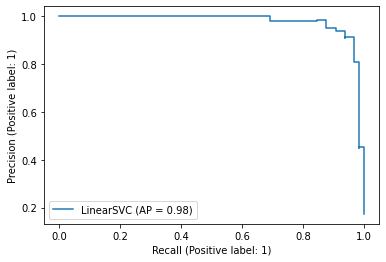

In [150]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(svclassifier, X_test, y_test)

In [151]:
from sklearn.metrics import classification_report
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[[307   3]
 [  6  59]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       310
           1       0.95      0.91      0.93        65

    accuracy                           0.98       375
   macro avg       0.97      0.95      0.96       375
weighted avg       0.98      0.98      0.98       375



"Precision" is $\frac{TP}{TP+FP}$. In other terms, the proportion of true positive classifications out of all positive classifications.
<br>
"Recall" is $\frac{TP}{TP+FN}$. In other terms, the proportion of true positive classifications out of all datapoints which were truly positive, whether classified as such or not.
<br>(Kundu, 2022)

This means that, on the valifation data, when the classifier determines a consignment as called for inspection, it gives fewer false negatives than false positives; when it classifies as not being called, it gives fewer false positives than false negatives. In other words, it tends to slightly over-assign the _yes_ category, and under-assign the _no_ category. This seems to be almost an over-compensation for the imbalance in the dataset!

We could potentially improve the accuracy of our model by using gradient descent to optimise the boundary between classes.

In [152]:
from sklearn.linear_model import SGDClassifier

graddescclassifier = SGDClassifier(loss='hinge', early_stopping=True, class_weight='balanced', random_state=42)

graddescclassifier.fit(X_train, y_train)
y_pred=graddescclassifier.predict(X_test)

In [153]:
print(confusion_matrix(y_test,y_pred))
crep = classification_report(y_test,y_pred)
print(crep)

[[304   6]
 [  3  62]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       310
           1       0.91      0.95      0.93        65

    accuracy                           0.98       375
   macro avg       0.95      0.97      0.96       375
weighted avg       0.98      0.98      0.98       375



This looks to have made a slight difference to our precision and recall values -- but could another model type perform better?

## Creating a decision tree classifier

Decision trees typically don't handle imbalanced datasets well, so it would be prudent to see the balance between our target classes:

In [154]:
yes = y[y['Called for inspection'] == 'Y'].count()
no = y[y['Called for inspection'] == 'N'].count()
rows = len(y)

print(yes[0], no[0])
print(f'\'Yes\' accounts for {yes[0]/rows:.2%} of consignments.\n\'No\' accounts for {no[0]/rows:.2%} of consignments.')

0 0
'Yes' accounts for 0.00% of consignments.
'No' accounts for 0.00% of consignments.


The target data is indeed unbalanced. 
<br>This means we will have to carry out some bagging in order to balance out the dataset: this involves sampling repeatedly from the dataset with replacement (so the same datapoint can be sampled more than once). 
<br>Using sklearn's BaggingClassifier allows us to easily perform bagging, and then implement the bagged training data to train and fit a decision tree. Note that this is different to a random forest: a bagged tree uses $M$ features when considering where to make a split, whereas a random forest uses $m<M$ features when making this same decision (Brownlee, 2020).

In [155]:
from sklearn.tree import DecisionTreeClassifier
treeclassifier = DecisionTreeClassifier(class_weight='balanced', random_state=42)

Decision trees are prone to overfitting; this means the decision function fits too closely to the training data, and the model cannot effectively axtrapolate beyond this and cope well with unseen data. One way to minimise the risk of this is tuning the max_depth parameter. Not setting a maximum depth, or setting it too high, allows the tree to split the training data into excessively small subsets ("splitting hairs", or creating false boundaries), leading to overfitting (Mithrakumar, 2019).

In [156]:
from sklearn.ensemble import BaggingClassifier

bagged_tree_score_dict = {}
bagged_tree_confusion_dict = {}

for max_d in range(1,21):
    treeclassifier.set_params(max_depth=max_d)
    baggedtreeclassifier = BaggingClassifier(estimator=treeclassifier)
    baggedtreeclassifier.fit(X_train, y_train)
    bagged_tree_score_dict[max_d] = baggedtreeclassifier.score(X_validate, y_validate)
    y_pred=baggedtreeclassifier.predict(X_validate)
    bagged_tree_confusion_dict[max_d] = confusion_matrix(y_validate,y_pred)

In [157]:
print(bagged_tree_score_dict)

{1: 0.9946666666666667, 2: 0.9946666666666667, 3: 0.9946666666666667, 4: 0.9973333333333333, 5: 0.9946666666666667, 6: 0.9946666666666667, 7: 0.992, 8: 0.992, 9: 0.9973333333333333, 10: 0.9973333333333333, 11: 0.9973333333333333, 12: 0.9946666666666667, 13: 0.9946666666666667, 14: 0.9973333333333333, 15: 0.9973333333333333, 16: 0.9973333333333333, 17: 0.992, 18: 0.992, 19: 0.9973333333333333, 20: 0.9973333333333333}


In [158]:
pprint.pp(bagged_tree_confusion_dict)

{1: array([[317,   1],
       [  1,  56]], dtype=int64),
 2: array([[317,   1],
       [  1,  56]], dtype=int64),
 3: array([[317,   1],
       [  1,  56]], dtype=int64),
 4: array([[318,   0],
       [  1,  56]], dtype=int64),
 5: array([[317,   1],
       [  1,  56]], dtype=int64),
 6: array([[317,   1],
       [  1,  56]], dtype=int64),
 7: array([[316,   2],
       [  1,  56]], dtype=int64),
 8: array([[316,   2],
       [  1,  56]], dtype=int64),
 9: array([[318,   0],
       [  1,  56]], dtype=int64),
 10: array([[318,   0],
       [  1,  56]], dtype=int64),
 11: array([[318,   0],
       [  1,  56]], dtype=int64),
 12: array([[317,   1],
       [  1,  56]], dtype=int64),
 13: array([[317,   1],
       [  1,  56]], dtype=int64),
 14: array([[318,   0],
       [  1,  56]], dtype=int64),
 15: array([[317,   1],
       [  0,  57]], dtype=int64),
 16: array([[318,   0],
       [  1,  56]], dtype=int64),
 17: array([[317,   1],
       [  2,  55]], dtype=int64),
 18: array([[317,   1],

In [159]:
#max_d = max(bagged_tree_score_dict.values())
max_d = [C for C, score in bagged_tree_score_dict.items() if score ==  max(bagged_tree_score_dict.values())]

In [160]:
max_d = max_d[0]

As we can see a max depth of 9 gives the best accuracy in terms of precision and recall.

In [161]:
treeclassifier.set_params(max_depth=max_d)

DecisionTreeClassifier(class_weight='balanced', max_depth=4, random_state=42)

In [162]:
y_pred_test = baggedtreeclassifier.predict(X_test)

In [163]:
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

[[309   1]
 [  3  62]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       310
           1       0.98      0.95      0.97        65

    accuracy                           0.99       375
   macro avg       0.99      0.98      0.98       375
weighted avg       0.99      0.99      0.99       375



The bagged decision tree outperforms the SVM, by having a lower error rate (higher accuracy). However, is this *too* high: is the model overfitting, as decision trees are prone to do? Cross-validation is a quick and easy way to analyse this.

In [164]:
from sklearn.model_selection import cross_validate
import pprint

for est in [svclassifier, graddescclassifier, baggedtreeclassifier]:
    cv = cross_validate(est, X, y.to_numpy().ravel()) 
    pprint.pprint(cv)

{'fit_time': array([0.01798177, 0.03445172, 0.01346993, 0.01571417, 0.01410651]),
 'score_time': array([0.        , 0.        , 0.        , 0.01562476, 0.        ]),
 'test_score': array([0.968, 0.98 , 0.986, 0.982, 0.972])}
{'fit_time': array([0.02178144, 0.01913929, 0.01614261, 0.02858114, 0.0125227 ]),
 'score_time': array([0.00805378, 0.0079155 , 0.        , 0.00447917, 0.        ]),
 'test_score': array([0.96 , 0.976, 0.96 , 0.978, 0.974])}
{'fit_time': array([0.16495371, 0.20825553, 0.20556426, 0.19838262, 0.18299842]),
 'score_time': array([0.        , 0.00752711, 0.        , 0.00578117, 0.01159692]),
 'test_score': array([0.984, 0.998, 1.   , 0.998, 0.988])}


The bagged decision tree takes (proportionally) much longer to fit and socre, indicating that it is more complex and thus less easily interpretable -- but the test scores are considerably higher than the linear SVM.

# References

de Amorim, L., Cavalcanti, G., & Cruz, R. (2023). 'The choice of scaling technique matters for classification performance',
_Applied Soft Computing_, Volume 133, 109924. DOI: https://doi.org/10.1016/j.asoc.2022.109924.
<br><br>Brownlee, J. (2020). 'Bagging and Random Forest for Imbalanced Classification, _Machine Learning Mastery_, 12 February. Available at: https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/
<br><br>Chong, J. (2020). 'What is Feature Scaling & Why is it Important in Machine Learning?', _Medium_, 30 December. Available at: https://towardsdatascience.com/what-is-feature-scaling-why-is-it-important-in-machine-learning-2854ae877048
<br><br>Debie, E. & Shafi, K. (2019). Implications of the curse of dimensionality for supervised learning classifier systems: theoretical and empirical analyses. Pattern Analysis and Applications. 22. DOI: 10.1007/s10044-017-0649-0. 
<br><br>Kundu, R. (2022). 'Precision vs. Recall: Differences, Use Cases & Evaluation', _v7labs_. 19 September. Available at: https://www.v7labs.com/blog/precision-vs-recall-guide
<br><br>Lindgren, I. (2020). 'Dealing with Highly Dimensional Data using Principal Component Analysis (PCA)', _Towards Data Science_. 24 April. Available at: https://towardsdatascience.com/dealing-with-highly-dimensional-data-using-principal-component-analysis-pca-fea1ca817fe6
<br><br>Mithrakumar, M. (2019). 'How to tune a Decision Tree?', _Towards Data Science_. 11 November. Available at: https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680
<br><br>Zach, 2022.'Label Encoding vs. One Hot Encoding: What’s the Difference?', _Statology_, 8 August. Available at: https://www.statology.org/label-encoding-vs-one-hot-encoding/
